In [ ]:
###Forecasting with a CNN

In [1]:
#Setup

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

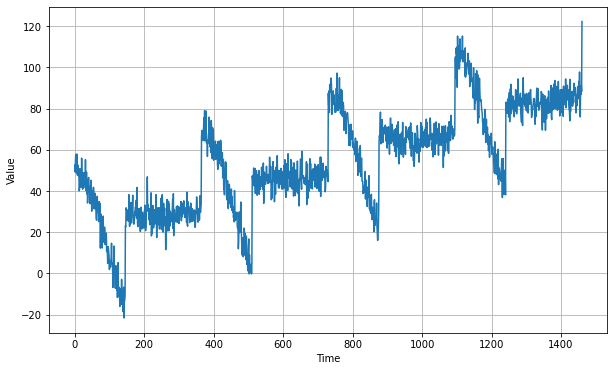

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
###Preprocessing With 1D-Convolutional Layers

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 12s 105ms/step - loss: 87.5409 - mae: 88.0403
Epoch 2/100
8/8 [==============================] - 1s 55ms/step - loss: 87.5482 - mae: 88.0477
Epoch 3/100
8/8 [==============================] - 1s 47ms/step - loss: 86.0839 - mae: 86.5832
Epoch 4/100
8/8 [==============================] - 1s 50ms/step - loss: 84.8699 - mae: 85.3692
Epoch 5/100
8/8 [==============================] - 1s 47ms/step - loss: 82.7797 - mae: 83.2790
Epoch 6/100
8/8 [==============================] - 1s 51ms/step - loss: 80.8773 - mae: 81.3768
Epoch 7/100
8/8 [==============================] - 1s 47ms/step - loss: 78.2117 - mae: 78.7111
Epoch 8/100
8/8 [==============================] - 1s 50ms/step - loss: 75.1198 - mae: 75.6193
Epoch 9/100
8/8 [==============================] - 1s 51ms/step - loss: 73.1414 - mae: 73.6410
Epoch 10/100
8/8 [==============================] - 1s 47ms/step - loss: 70.3368 - mae: 70.8364
Epoch 11/100
8/8 [=============================

8/8 [==============================] - 1s 49ms/step - loss: 11.7322 - mae: 12.2232
Epoch 86/100
8/8 [==============================] - 1s 48ms/step - loss: 13.0043 - mae: 13.4972
Epoch 87/100
8/8 [==============================] - 1s 52ms/step - loss: 10.7063 - mae: 11.1969
Epoch 88/100
8/8 [==============================] - 1s 53ms/step - loss: 15.1515 - mae: 15.6451
Epoch 89/100
8/8 [==============================] - 1s 51ms/step - loss: 22.4311 - mae: 22.9281
Epoch 90/100
8/8 [==============================] - 1s 55ms/step - loss: 14.1845 - mae: 14.6756
Epoch 91/100
8/8 [==============================] - 1s 48ms/step - loss: 17.9477 - mae: 18.4422
Epoch 92/100
8/8 [==============================] - 1s 53ms/step - loss: 17.9350 - mae: 18.4303
Epoch 93/100
8/8 [==============================] - 1s 54ms/step - loss: 11.7571 - mae: 12.2474
Epoch 94/100
8/8 [==============================] - 1s 50ms/step - loss: 21.4043 - mae: 21.8990
Epoch 95/100
8/8 [==============================] - 1

(1e-08, 0.0001, 0.0, 30.0)

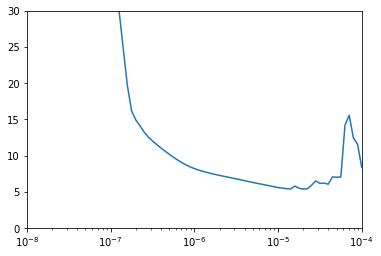

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                 batch_size = 128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                  batch_size = 128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters = 32, kernel_size = 5,
                       strides = 1, padding = "causal",
                       activation = "relu",
                       input_shape = [None, 1]),
    keras.layers.LSTM(32, return_sequences = True),
    keras.layers.LSTM(32, return_sequences = True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200)
])

optimizer = keras.optimizers.SGD(lr = 1e-5, momentum = 0.9)
model.compile(loss = keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only = True)
early_stopping = keras.callbacks.EarlyStopping(patience = 50)
model.fit(train_set, epochs = 500,
         validation_data = valid_set,
         callbacks = [early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 10s 314ms/step - loss: 69.6428 - mae: 70.1422 - val_loss: 28.7748 - val_mae: 29.2719
Epoch 2/500
8/8 [==============================] - 1s 79ms/step - loss: 28.4441 - mae: 28.9408 - val_loss: 38.9231 - val_mae: 39.4212
Epoch 3/500
8/8 [==============================] - 1s 105ms/step - loss: 17.9295 - mae: 18.4251 - val_loss: 30.1022 - val_mae: 30.6010
Epoch 4/500
8/8 [==============================] - 1s 92ms/step - loss: 12.3401 - mae: 12.8300 - val_loss: 24.5627 - val_mae: 25.0602
Epoch 5/500
8/8 [==============================] - 1s 75ms/step - loss: 10.3271 - mae: 10.8153 - val_loss: 18.8857 - val_mae: 19.3824
Epoch 6/500
8/8 [==============================] - 1s 88ms/step - loss: 8.9436 - mae: 9.4297 - val_loss: 16.0110 - val_mae: 16.5059
Epoch 7/500
8/8 [==============================] - 1s 76ms/step - loss: 8.3553 - mae: 8.8417 - val_loss: 12.5160 - val_mae: 13.0055
Epoch 8/500
8/8 [==============================] - 1s 74ms/step

8/8 [==============================] - 1s 90ms/step - loss: 4.5429 - mae: 5.0189 - val_loss: 6.3868 - val_mae: 6.8709
Epoch 64/500
8/8 [==============================] - 1s 76ms/step - loss: 4.4823 - mae: 4.9587 - val_loss: 6.6531 - val_mae: 7.1365
Epoch 65/500
8/8 [==============================] - 1s 103ms/step - loss: 4.5307 - mae: 5.0076 - val_loss: 5.9730 - val_mae: 6.4550
Epoch 66/500
8/8 [==============================] - 1s 102ms/step - loss: 4.5616 - mae: 5.0390 - val_loss: 6.2274 - val_mae: 6.7103
Epoch 67/500
8/8 [==============================] - 1s 108ms/step - loss: 4.5409 - mae: 5.0174 - val_loss: 6.5298 - val_mae: 7.0140
Epoch 68/500
8/8 [==============================] - 1s 101ms/step - loss: 4.5691 - mae: 5.0456 - val_loss: 6.1021 - val_mae: 6.5845
Epoch 69/500
8/8 [==============================] - 1s 113ms/step - loss: 4.5174 - mae: 4.9948 - val_loss: 6.2072 - val_mae: 6.6908
Epoch 70/500
8/8 [==============================] - 1s 97ms/step - loss: 4.4810 - mae: 4.95

8/8 [==============================] - 1s 70ms/step - loss: 4.3229 - mae: 4.7973 - val_loss: 5.6944 - val_mae: 6.1766
Epoch 126/500
8/8 [==============================] - 1s 69ms/step - loss: 4.3356 - mae: 4.8102 - val_loss: 5.6647 - val_mae: 6.1462
Epoch 127/500
8/8 [==============================] - 1s 67ms/step - loss: 4.2905 - mae: 4.7654 - val_loss: 5.7805 - val_mae: 6.2631
Epoch 128/500
8/8 [==============================] - 1s 76ms/step - loss: 4.2875 - mae: 4.7621 - val_loss: 5.5422 - val_mae: 6.0216
Epoch 129/500
8/8 [==============================] - 1s 72ms/step - loss: 4.3098 - mae: 4.7843 - val_loss: 5.6050 - val_mae: 6.0865
Epoch 130/500
8/8 [==============================] - 1s 67ms/step - loss: 4.3194 - mae: 4.7933 - val_loss: 5.7371 - val_mae: 6.2196
Epoch 131/500
8/8 [==============================] - 1s 78ms/step - loss: 4.2939 - mae: 4.7689 - val_loss: 5.6339 - val_mae: 6.1159
Epoch 132/500
8/8 [==============================] - 1s 88ms/step - loss: 4.3022 - mae: 4.

Epoch 187/500
8/8 [==============================] - 1s 83ms/step - loss: 4.1730 - mae: 4.6464 - val_loss: 5.5442 - val_mae: 6.0260
Epoch 188/500
8/8 [==============================] - 1s 84ms/step - loss: 4.1246 - mae: 4.5978 - val_loss: 5.3174 - val_mae: 5.7970
Epoch 189/500
8/8 [==============================] - 1s 116ms/step - loss: 4.2023 - mae: 4.6760 - val_loss: 5.4122 - val_mae: 5.8928
Epoch 190/500
8/8 [==============================] - 1s 95ms/step - loss: 4.1626 - mae: 4.6359 - val_loss: 5.3710 - val_mae: 5.8513
Epoch 191/500
8/8 [==============================] - 1s 85ms/step - loss: 4.2062 - mae: 4.6805 - val_loss: 5.6395 - val_mae: 6.1214
Epoch 192/500
8/8 [==============================] - 1s 81ms/step - loss: 4.2016 - mae: 4.6753 - val_loss: 5.5046 - val_mae: 5.9863
Epoch 193/500
8/8 [==============================] - 1s 81ms/step - loss: 4.1615 - mae: 4.6344 - val_loss: 5.6972 - val_mae: 6.1787
Epoch 194/500
8/8 [==============================] - 1s 95ms/step - loss: 4

8/8 [==============================] - 1s 77ms/step - loss: 4.0793 - mae: 4.5510 - val_loss: 5.2877 - val_mae: 5.7683
Epoch 250/500
8/8 [==============================] - 1s 72ms/step - loss: 4.0860 - mae: 4.5582 - val_loss: 5.3457 - val_mae: 5.8264
Epoch 251/500
8/8 [==============================] - 1s 71ms/step - loss: 4.0760 - mae: 4.5489 - val_loss: 5.2540 - val_mae: 5.7335
Epoch 252/500
8/8 [==============================] - 1s 89ms/step - loss: 4.1175 - mae: 4.5892 - val_loss: 5.1685 - val_mae: 5.6476
Epoch 253/500
8/8 [==============================] - 1s 83ms/step - loss: 4.1157 - mae: 4.5873 - val_loss: 5.1595 - val_mae: 5.6380
Epoch 254/500
8/8 [==============================] - 1s 75ms/step - loss: 4.1185 - mae: 4.5911 - val_loss: 5.1760 - val_mae: 5.6544
Epoch 255/500
8/8 [==============================] - 1s 73ms/step - loss: 4.0987 - mae: 4.5716 - val_loss: 5.3375 - val_mae: 5.8186
Epoch 256/500
8/8 [==============================] - 1s 77ms/step - loss: 4.1213 - mae: 4.

8/8 [==============================] - 1s 77ms/step - loss: 4.0894 - mae: 4.5613 - val_loss: 5.3266 - val_mae: 5.8076
Epoch 312/500
8/8 [==============================] - 1s 75ms/step - loss: 4.0737 - mae: 4.5453 - val_loss: 5.0733 - val_mae: 5.5525
Epoch 313/500
8/8 [==============================] - 1s 74ms/step - loss: 4.1045 - mae: 4.5768 - val_loss: 5.0705 - val_mae: 5.5479
Epoch 314/500
8/8 [==============================] - 1s 85ms/step - loss: 4.1019 - mae: 4.5737 - val_loss: 5.1205 - val_mae: 5.5993
Epoch 315/500
8/8 [==============================] - 1s 87ms/step - loss: 4.1008 - mae: 4.5717 - val_loss: 5.3247 - val_mae: 5.8056
Epoch 316/500
8/8 [==============================] - 1s 78ms/step - loss: 4.1013 - mae: 4.5732 - val_loss: 5.3329 - val_mae: 5.8139
Epoch 317/500
8/8 [==============================] - 1s 78ms/step - loss: 4.0874 - mae: 4.5600 - val_loss: 5.2709 - val_mae: 5.7514
Epoch 318/500
8/8 [==============================] - 1s 100ms/step - loss: 4.0550 - mae: 4

8/8 [==============================] - 1s 86ms/step - loss: 4.0662 - mae: 4.5371 - val_loss: 5.0126 - val_mae: 5.4915
Epoch 374/500
8/8 [==============================] - 1s 81ms/step - loss: 4.0572 - mae: 4.5273 - val_loss: 5.1368 - val_mae: 5.6165
Epoch 375/500
8/8 [==============================] - 1s 72ms/step - loss: 4.0559 - mae: 4.5277 - val_loss: 5.5695 - val_mae: 6.0494
Epoch 376/500
8/8 [==============================] - 1s 86ms/step - loss: 4.0839 - mae: 4.5564 - val_loss: 5.3621 - val_mae: 5.8430
Epoch 377/500
8/8 [==============================] - 1s 80ms/step - loss: 4.0857 - mae: 4.5572 - val_loss: 5.2855 - val_mae: 5.7658
Epoch 378/500
8/8 [==============================] - 1s 101ms/step - loss: 4.0277 - mae: 4.4986 - val_loss: 5.2592 - val_mae: 5.7399
Epoch 379/500
8/8 [==============================] - 1s 96ms/step - loss: 4.1008 - mae: 4.5724 - val_loss: 5.3643 - val_mae: 5.8456
Epoch 380/500
8/8 [==============================] - 1s 102ms/step - loss: 4.0530 - mae: 

In [17]:
model = keras.models.load_model("my_checkpoint.h5")

In [18]:
rnn_forecast = model_forecast(model, series[:, np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

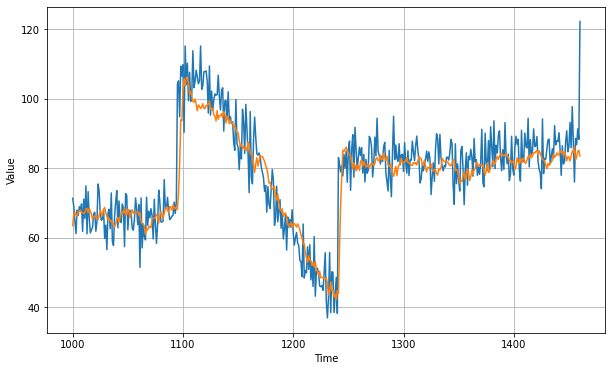

In [19]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [22]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.1125836

In [ ]:
###Fully Convolutional Forecasting

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                  batch_size = 128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
    keras.layers.Conv1D(filters = 32,
                       kernel_size = 2,
                       strides = 1,
                       dilation_rate = dilation_rate, 
                       padding = "causal",
                       activation = "relu")
)

model.add(keras.layers.Conv1D(filters = 1, kernel_size = 1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10 ** (epoch / 30))

optimizer = keras.optimizers.Adam(lr=1e-4)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 5s 73ms/step - loss: 42.1080 - mae: 42.6069
Epoch 2/100
8/8 [==============================] - 1s 90ms/step - loss: 41.2128 - mae: 41.7118
Epoch 3/100
8/8 [==============================] - 1s 89ms/step - loss: 41.9048 - mae: 42.4040
Epoch 4/100
8/8 [==============================] - 1s 101ms/step - loss: 41.4798 - mae: 41.9787
Epoch 5/100
8/8 [==============================] - 1s 90ms/step - loss: 40.6822 - mae: 41.1811
Epoch 6/100
8/8 [==============================] - 1s 74ms/step - loss: 39.9483 - mae: 40.4471
Epoch 7/100
8/8 [==============================] - 1s 78ms/step - loss: 38.0290 - mae: 38.5276
Epoch 8/100
8/8 [==============================] - 1s 93ms/step - loss: 37.2201 - mae: 37.7189
Epoch 9/100
8/8 [==============================] - 1s 79ms/step - loss: 34.3747 - mae: 34.8731
Epoch 10/100
8/8 [==============================] - 1s 85ms/step - loss: 29.1636 - mae: 29.6615
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 1s 62ms/step - loss: 9.1774 - mae: 9.6637
Epoch 86/100
8/8 [==============================] - 1s 61ms/step - loss: 7.1592 - mae: 7.6430
Epoch 87/100
8/8 [==============================] - 1s 59ms/step - loss: 7.4921 - mae: 7.9770
Epoch 88/100
8/8 [==============================] - 1s 61ms/step - loss: 7.9884 - mae: 8.4723
Epoch 89/100
8/8 [==============================] - 1s 60ms/step - loss: 13.6709 - mae: 14.1599
Epoch 90/100
8/8 [==============================] - 1s 69ms/step - loss: 8.0776 - mae: 8.5624
Epoch 91/100
8/8 [==============================] - 1s 60ms/step - loss: 7.1354 - mae: 7.6203
Epoch 92/100
8/8 [==============================] - 1s 63ms/step - loss: 9.1902 - mae: 9.6796
Epoch 93/100
8/8 [==============================] - 1s 62ms/step - loss: 8.3731 - mae: 8.8607
Epoch 94/100
8/8 [==============================] - 1s 64ms/step - loss: 16.9496 - mae: 17.4427
Epoch 95/100
8/8 [==============================] - 1s 72ms/step - lo

(0.0001, 0.1, 0.0, 30.0)

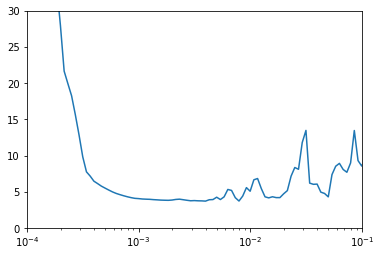

In [26]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [28]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape = [None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
        keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
    
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

optimizer = keras.optimizers.Adam(lr = 3e-4)

model.compile(loss = keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 7s 290ms/step - loss: 40.2814 - mae: 40.7803 - val_loss: 72.9189 - val_mae: 73.4189
Epoch 2/500
8/8 [==============================] - 1s 126ms/step - loss: 37.8895 - mae: 38.3882 - val_loss: 67.9778 - val_mae: 68.4778
Epoch 3/500
8/8 [==============================] - 2s 161ms/step - loss: 36.0522 - mae: 36.5509 - val_loss: 60.8665 - val_mae: 61.3665
Epoch 4/500
8/8 [==============================] - 1s 141ms/step - loss: 31.9605 - mae: 32.4587 - val_loss: 50.2195 - val_mae: 50.7191
Epoch 5/500
8/8 [==============================] - 1s 149ms/step - loss: 26.0540 - mae: 26.5512 - val_loss: 36.6520 - val_mae: 37.1480
Epoch 6/500
8/8 [==============================] - 1s 130ms/step - loss: 20.5578 - mae: 21.0523 - val_loss: 32.0186 - val_mae: 32.5158
Epoch 7/500
8/8 [==============================] - 1s 126ms/step - loss: 18.8428 - mae: 19.3376 - val_loss: 30.0781 - val_mae: 30.5755
Epoch 8/500
8/8 [==============================] - 1s 1

Epoch 63/500
8/8 [==============================] - 1s 128ms/step - loss: 3.8033 - mae: 4.2732 - val_loss: 4.2411 - val_mae: 4.7152
Epoch 64/500
8/8 [==============================] - 1s 110ms/step - loss: 3.7721 - mae: 4.2422 - val_loss: 4.2520 - val_mae: 4.7266
Epoch 65/500
8/8 [==============================] - 1s 114ms/step - loss: 3.7716 - mae: 4.2412 - val_loss: 4.2552 - val_mae: 4.7294
Epoch 66/500
8/8 [==============================] - 1s 108ms/step - loss: 3.7710 - mae: 4.2413 - val_loss: 4.3180 - val_mae: 4.7953
Epoch 67/500
8/8 [==============================] - 1s 106ms/step - loss: 3.7675 - mae: 4.2362 - val_loss: 4.2530 - val_mae: 4.7271
Epoch 68/500
8/8 [==============================] - 1s 106ms/step - loss: 3.7479 - mae: 4.2180 - val_loss: 4.2238 - val_mae: 4.6978
Epoch 69/500
8/8 [==============================] - 1s 145ms/step - loss: 3.7568 - mae: 4.2259 - val_loss: 4.3084 - val_mae: 4.7856
Epoch 70/500
8/8 [==============================] - 1s 121ms/step - loss: 3.

Epoch 125/500
8/8 [==============================] - 1s 111ms/step - loss: 3.4794 - mae: 3.9420 - val_loss: 4.1964 - val_mae: 4.6720
Epoch 126/500
8/8 [==============================] - 1s 129ms/step - loss: 3.4850 - mae: 3.9476 - val_loss: 4.2130 - val_mae: 4.6892
Epoch 127/500
8/8 [==============================] - 1s 139ms/step - loss: 3.5161 - mae: 3.9792 - val_loss: 4.2908 - val_mae: 4.7674
Epoch 128/500
8/8 [==============================] - 1s 137ms/step - loss: 3.4781 - mae: 3.9401 - val_loss: 4.2050 - val_mae: 4.6806
Epoch 129/500
8/8 [==============================] - 1s 123ms/step - loss: 3.4907 - mae: 3.9527 - val_loss: 4.1993 - val_mae: 4.6747
Epoch 130/500
8/8 [==============================] - 1s 113ms/step - loss: 3.4808 - mae: 3.9425 - val_loss: 4.2539 - val_mae: 4.7305
Epoch 131/500
8/8 [==============================] - 1s 114ms/step - loss: 3.4814 - mae: 3.9437 - val_loss: 4.2724 - val_mae: 4.7486
Epoch 132/500
8/8 [==============================] - 1s 121ms/step - 

In [29]:
model = keras.models.load_model("my_checkpoint.h5")

In [30]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size: -1, -1, 0]

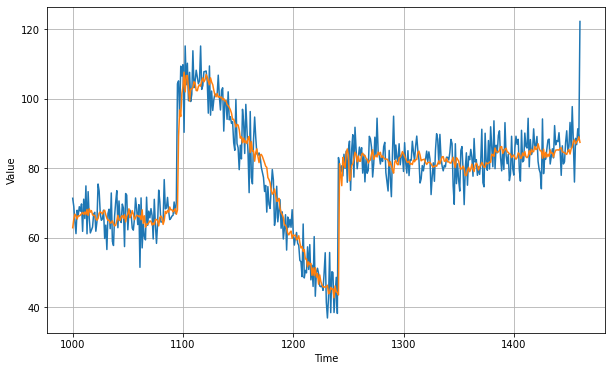

In [31]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [32]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.529537